# Development steps

1. IAM role image handling;
2. ECR image
3. Lambda function creation;
4. API Gateway


## IAM Role Image Handling

The first step: create a user on IAM with below permissions:

- **IAMUserChangePassword**: a default permission to change password 
- **IAMFullAccess**: Allows IAM management
- **AmazonEC2ContainerRegistryFullAccess**: Allows uploading image to ECR
- **AWSLambda_FullAccess**: Allows access to specific Lambda function given a role 
- **AmazonAPIGatewayAdministrator**: Allows access to specific API Gateway handling 

## ECR

1. Log in on ECR account;
2. Delete existent ECR image;
3. Create ECR image;
4. Build docker image;
5. Tag docker image;
6. Push docker image to ECR.

## Lambda function

1. Create lambda function;
2. Test lambda function.

## API Gateway

1. Create REST API
2. Create API resource
3. Create REST method
4. Set up integration with the Lambda function
5. Deploy API
6. Create API key
7. Create usage plan
8. Associate the usage plan with the API key
9. Grant API Gateway permission to invoke the Lambda function


# Deployment pipeline

In [20]:
from os import getcwd
from deploy.core import do_deploy

image_name='lambda-api-example'
lambda_name='test_function'
lambda_description='A test Lambda function'
api_name='my-api'
api_endpoint='predict'
api_stage='test'
lambda_method_verb='POST'

activity_info_ = {
    'image_name': lambda_name,
    "lambda_function_name": lambda_name,
    'lambda_function_description': lambda_description,
    "rest_api_name": api_name,
    'endpoint': api_endpoint,
    'method_verb': lambda_method_verb,
    'stage': api_stage
}

# Load environment variables from .env
base_path=getcwd()+'/deploy'

configuration_info_={
    'environment_path': base_path+'/.env',
    'trust_policy_path': base_path,
    'usage_constraints_path': base_path
}

deployment_info=do_deploy(activity_info_, configuration_info_)

Loaded JSON: /home/brunolnetto/github/trouchet/lambda-api/deploy/api_usage_constraints.json
Loaded JSON: /home/brunolnetto/github/trouchet/lambda-api/deploy/trust_policy.json
Starting execution of Deployment of ML solution...
Starting execution of ECR image upload...
Logging in on ECR account...
Creating ECR image...
Building docker image...
Tagging docker image...
Pushing docker image to ECR...
Finished execution of ECR image upload.
Time taken: 63.16 seconds
Starting execution of IAM policies update...
Finished execution of IAM policies update.
Time taken: 5.97 seconds
Starting execution of Lambda function deployment...
Creating Lambda Function test_function...
Lambda deployment is still in progress. Waiting...
Lambda deployment is still in progress. Waiting...
Lambda deployment is still in progress. Waiting...
Lambda deployment is still in progress. Waiting...
Lambda function deployment duration: 16.16 seconds
Finished execution of Lambda function deployment.
Time taken: 23.60 secon

In [3]:
from os import getcwd 
from deploy.core import deploy_application

info_environment_path=getcwd()+'/.env'

deployment_info=deploy_application(info_environment_path)

Loaded JSON: /home/brunolnetto/github/trouchet/lambda-api/deploy/api_usage_constraints.json
Loaded JSON: /home/brunolnetto/github/trouchet/lambda-api/deploy/trust_policy.json
Starting execution of Deployment of ML solution...
Starting execution of ECR image upload...
Logging in on ECR account...
Deleting existent ECR image...
Creating ECR image...
Building docker image...
Tagging docker image...
Pushing docker image to ECR...
Finished execution of ECR image upload.
Time taken: 51.74 seconds
Starting execution of IAM policies update...
Finished execution of IAM policies update.
Time taken: 0.91 seconds
Starting execution of Lambda function deployment...
Updating Lambda Function test_function...
Finished execution of Lambda function deployment.
Time taken: 1.74 seconds
Starting execution of API endpoint deployment...
An error occurred (ConflictException) when calling the CreateUsagePlanKey operation: Usage Plan 53isao cannot be added because API Key xxnm3md6p0 cannot reference multiple U

In [6]:
from json import dump

from os import getcwd
from os import getenv
from dotenv import load_dotenv

info_environment_path=getcwd()+'/.env'

load_dotenv(info_environment_path)
lambda_method_verb=getenv('LAMBDA_METHOD_VERB')

# Retrieve information from deployment response
api_key=deployment_info['api_key']
api_url = deployment_info['api_url']

deployment_response = {
    'api_key': api_key,
    'api_url': api_url,
    'method_verb': lambda_method_verb,
    # Add other information as needed
}

# Save the deployment information to a JSON file
deployment_info_filename = "deployment_info.json"

with open(deployment_info_filename, 'w') as json_file:
    dump(deployment_response, json_file)

print(f"Deployment information saved to {deployment_info_filename}")

Deployment information saved to deployment_info.json


In [7]:
from json import load

# Save the deployment information to a JSON file
deployment_info_filename = "deployment_info.json"

with open(deployment_info_filename, 'r') as json_file:
    json_payload=load(json_file)

method_verb=json_payload['method_verb']
api_key=json_payload['api_key']
api_url=json_payload['api_url']

print(f"Deployment information loaded from {deployment_info_filename}")

Deployment information loaded from deployment_info.json


In [13]:
from requests import post
from deploy.utils.misc import timing


def post_query(api_url_, api_key_, example_):
    msg=f'Squared array of length {len(example_)}'
    
    @timing(msg)
    def post_query_temp(api_url, api_key, example):
        headers = {
            'Content-type': 'application/json', 
            'x-api-key': api_key_,
        }

        resp = post(api_url_, headers=headers, json=example_)
    
        # Check the response and handle it accordingly
        if resp.status_code == 200:
            return resp.json()
        else:
            return resp.text

    return post_query_temp(api_url_, api_key_, example_)

In [10]:
import json
import numpy as np

# Prepare the event to pass to the Lambda function
example=[1,2,3,4,5,6,7,8,9,10,11,12]

response=post_query(api_url, api_key, example)

print(response)

Starting execution of Squared array of length 12...
Finished execution of Squared array of length 12.
Time taken: 1.62 seconds
[1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144]


In [41]:
# WIP
import json
import requests
from about_time import about_time
from numpy.random import rand

# Prepare the event to pass to the Lambda function
curr_example=[]
range_len=20
span_width=10000
final_sizes=[]
durations=[]

with about_time() as total_t:
    for size_multiplier in range(range_len):
        with about_time() as single_t:
            # Transform into json format
            post_query(api_url, api_key, curr_example)
        
        lst_to_append=list(rand(span_width))
        
        final_sizes.append(len(curr_example))
        
        curr_example = curr_example + lst_to_append
        
        durations.append(single_t.duration_human)
        

Starting execution of Squared array of length 0...
Finished execution of Squared array of length 0.
Time taken: 1.26 seconds
Starting execution of Squared array of length 10000...
Finished execution of Squared array of length 10000.
Time taken: 1.15 seconds
Starting execution of Squared array of length 20000...
Finished execution of Squared array of length 20000.
Time taken: 1.62 seconds
Starting execution of Squared array of length 30000...
Finished execution of Squared array of length 30000.
Time taken: 2.07 seconds
Starting execution of Squared array of length 40000...
Finished execution of Squared array of length 40000.
Time taken: 2.63 seconds
Starting execution of Squared array of length 50000...
Finished execution of Squared array of length 50000.
Time taken: 2.86 seconds
Starting execution of Squared array of length 60000...
Finished execution of Squared array of length 60000.
Time taken: 3.04 seconds
Starting execution of Squared array of length 70000...
Finished execution of 

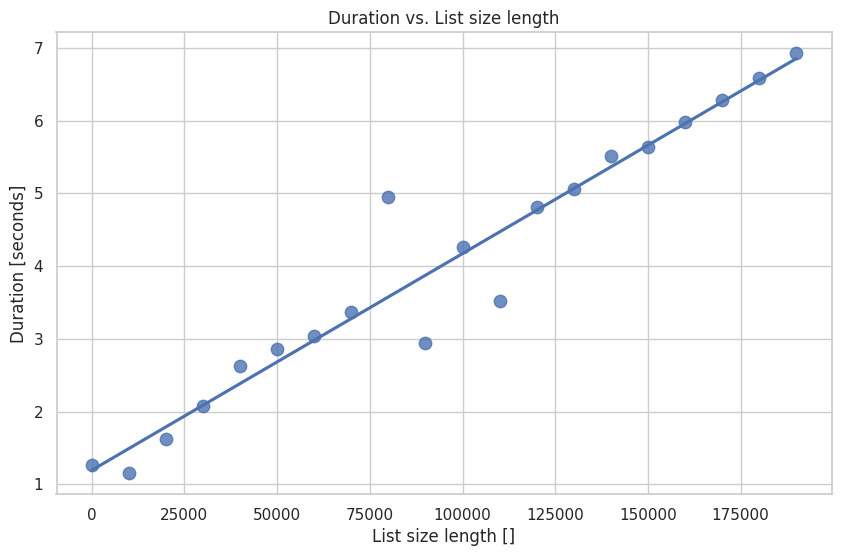

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your duration_values and final_sizes data
duration_values = [duration.value for duration in durations]

# Create a Seaborn plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(x=final_sizes, y=duration_values, marker='o', scatter_kws={'s': 80}, color='b', ci=None)
plt.xlabel('List size length []')
plt.ylabel('Duration [seconds]')
plt.title('Duration vs. List size length')
plt.show()